In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import re
import json
import string
from spellchecker import SpellChecker
import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pathlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
### get data ###

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print('train dataset : ', train_df.shape)
print('test dataset : ', test_df.shape)

train dataset :  (7613, 5)
test dataset :  (3263, 4)


In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<AxesSubplot:xlabel='target', ylabel='count'>

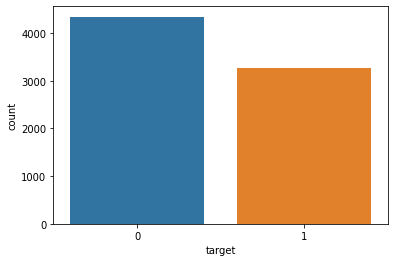

In [5]:
# class distribution
sns.countplot(data=train_df, x='target')

In [6]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
# explicit example

print('negative example : ', train_df[train_df["target"] == 0]["text"].values[1])
print('positive example : ', train_df[train_df["target"] == 1]["text"].values[1])

negative example :  I love fruits
positive example :  Forest fire near La Ronge Sask. Canada


In [8]:
# difficult example

print('negative example : ', train_df[train_df["target"] == 0]["text"].values[89])
print('positive example : ', train_df[train_df["target"] == 1]["text"].values[10])

negative example :  Leading emergency services boss welcomes new ambulance charity http://t.co/Mj2jQ2pSv6
positive example :  Three people died from the heat wave so far


### 1. Text cleaning

In [9]:
# keep only text tweet and target columns
train_df = train_df[['text', 'target']]
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# we use spacy for text processing 

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

In [11]:
# example nlp + lemmatization

a = nlp(train_df['text'].loc[0])
print(a)
[element.lemma_ for element in a]

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


['our',
 'deed',
 'be',
 'the',
 'reason',
 'of',
 'this',
 '#',
 'earthquake',
 'may',
 'ALLAH',
 'forgive',
 'we',
 'all']

In [12]:
# example link in tweet 

train_df.loc[train_df['text'].str.contains('http')].iloc[22, 0]

'#NowPlaying: Rene Ablaze &amp; Ian Buff - Magnitude http://t.co/Av2JSjfFtc  #EDM'

In [13]:
#How many http words has this text?
train_df.loc[train_df['text'].str.contains('http')].target.value_counts()

1    2172
0    1799
Name: target, dtype: int64

In [14]:
spell = SpellChecker()

# this function takes too much time to compute : we are not using it
def correct_spellings(x, spell=spell):
    ### correct the misspelled words of a given tweet ###
    x = x.split()
    misspelled = spell.unknown(x)
    result = map(lambda word : spell.correction(word) if word in misspelled and spell.correction(word) is not None else word, x)
    return " ".join(result)

def tweets_cleaning(x, correct_spelling=False, remove_emojis=True, remove_stop_words_lemmatization=True):
    ### Apply function to a clean a tweet ###

    # remove multiple spaces and lower characters
    x = x.replace(" +"," ").lower().strip()
    # remove urls
    url = re.compile(r'https?://\S+|www\.\S+')
    x = url.sub(r'',x)
    # remove html tags
    html = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    x = html.sub('',x)
    # remove non alpha-numeric characters
    x = ''.join([ch for ch in x if ch.isalnum() or ch==" "])

    if remove_emojis:
        x = x.encode('ascii', 'ignore').decode('utf8').strip()
    if correct_spelling:
        x = correct_spellings(x)
    if remove_stop_words_lemmatization:
        x = " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)])
    return x

## apply the cleaning function to the text column for train and test
train_df['cleaned_text'] = train_df['text'].apply(tweets_cleaning)
test_df['cleaned_text'] = test_df['text'].apply(tweets_cleaning)

In [15]:
train_df['cleaned_text']

0                    deed reason earthquake allah forgive
1                   forest fire near la ronge sask canada
2       resident ask shelter place notify officer evac...
3       13000 people receive wildfire evacuation order...
4       got send photo ruby alaska smoke wildfire pour...
                              ...                        
7608         giant crane hold bridge collapse nearby home
7609    ariaahrary thetawniest control wild fire calif...
7610                   m194 0104 utc5 km s volcano hawaii
7611    police investigate ebike collide car little po...
7612    late home raze northern california wildfire   ...
Name: cleaned_text, Length: 7613, dtype: object

In [16]:
train_df.shape

(7613, 3)

In [ ]:
# How many unique words have this text
def counter_word(text):
    count = dict()
    for row in text.values:
        for word in row.split():
            try:
                count[word] += 1
            except KeyError:
                count[word] = 1
    return count

counter = counter_word(train_df['cleaned_text'])

#for key, value in sorted(counter.items(), key=lambda item: item[1], reverse=True):
#    print(key, value)

In [18]:
len(counter)

15459

### 2. Tokenization

In [19]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=2000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(train_df["cleaned_text"])
train_df["text_encoded"] = tokenizer.texts_to_sequences(train_df["cleaned_text"])
test_df["text_encoded"] = tokenizer.texts_to_sequences(test_df["cleaned_text"])

In [20]:
train_df.head()

,text,target,cleaned_text,text_encoded
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[1, 411, 174, 1381, 1936]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[122, 3, 162, 491, 1, 1, 1019]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[1382, 442, 1708, 326, 1, 291, 189, 1708, 326,..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,"[1, 8, 1, 70, 189, 279, 36]"
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[267, 182, 126, 1, 1523, 175, 70, 1, 114]"


In [21]:
test_df.head()

,id,keyword,location,text,cleaned_text,text_encoded
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash,"[170, 1544, 46, 14]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe,"[130, 174, 940, 119, 369, 1053]"
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save,"[122, 3, 523, 1, 1, 1, 383, 99]"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,"[389, 1, 1, 70]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,"[378, 525, 12, 1, 247, 944]"


In [22]:
text_train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_df.text_encoded, padding="post")
text_test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_df.text_encoded, padding="post", maxlen = 25)

In [23]:
text_train_pad[0]

array([   1,  411,  174, 1381, 1936,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [24]:
text_test_pad[0]

array([ 170, 1544,   46,   14,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [25]:
text_train_pad.shape

(7613, 25)

In [26]:
text_test_pad.shape

(3263, 25)

In [27]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(text_train_pad,train_df.target, test_size=0.20)

In [28]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [29]:
for tweet, target in train.take(2):
    print('x:',tweet)
    print('y:',target)

x: tf.Tensor(
[  1   1  52   1 968   1  21  44 818   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int32)
y: tf.Tensor(1, shape=(), dtype=int64)
x: tf.Tensor(
[ 54 466 207   1   1  10 116 168 112 131 128 211  94   1   1   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int32)
y: tf.Tensor(0, shape=(), dtype=int64)


In [30]:
len(train)

6090

In [31]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [32]:
# Regardons un batch 
for tweet, target in train_batch.take(1):
  print(tweet, target)

tf.Tensor(
[[ 671  546  406 ...    0    0    0]
 [   1    1   40 ...    0    0    0]
 [ 537  873  925 ...    0    0    0]
 ...
 [ 558   20  588 ...    0    0    0]
 [ 416   18    0 ...    0    0    0]
 [   1 1122    2 ...    0    0    0]], shape=(64, 25), dtype=int32) tf.Tensor(
[0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1
 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 1], shape=(64,), dtype=int64)


### 3. Creating models

#### **Base model**

In [33]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                # Couche d'Input Word Embedding           
                tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim = 16, input_length = 25, name="embedding"),
                # Global average pooling
                tf.keras.layers.GlobalAveragePooling1D(),
                # Couche Dense classique
                #tf.keras.layers.Dense(16, activation='relu'),
                tf.keras.layers.Dense(8, activation='relu'),
                # Couche de sortie avec une fonction d'activation sigmoid
                tf.keras.layers.Dense(1, activation="sigmoid")
])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 16)            32016     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 32,161
Trainable params: 32,161
Non-trainable params: 0
_________________________________________________________________


In [35]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [36]:
history = model.fit(train_batch, 
                    epochs=20, 
                    validation_data=val_batch)

Epoch 1/20
96/96 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.5675 - val_loss: 0.6647 - val_accuracy: 0.5817
Epoch 2/20
96/96 [==============================] - 0s 2ms/step - loss: 0.6552 - accuracy: 0.5887 - val_loss: 0.6316 - val_accuracy: 0.6467
Epoch 3/20
96/96 [==============================] - 0s 2ms/step - loss: 0.6099 - accuracy: 0.6791 - val_loss: 0.5798 - val_accuracy: 0.7584
Epoch 4/20
96/96 [==============================] - 0s 2ms/step - loss: 0.5463 - accuracy: 0.7677 - val_loss: 0.5207 - val_accuracy: 0.7938
Epoch 5/20
96/96 [==============================] - 0s 1ms/step - loss: 0.4836 - accuracy: 0.8118 - val_loss: 0.4776 - val_accuracy: 0.8135
Epoch 6/20
96/96 [==============================] - 0s 1ms/step - loss: 0.4359 - accuracy: 0.8319 - val_loss: 0.4491 - val_accuracy: 0.8155
Epoch 7/20
96/96 [==============================] - 0s 1ms/step - loss: 0.4032 - accuracy: 0.8406 - val_loss: 0.4373 - val_accuracy: 0.8135
Epoch 8/20
96/96 [==

In [37]:
model.save("logs/model/model_base.h5")
json.dump(model.history.history, open("./logs/history/base_history.json", 'w'))

#### **SimpleRNN**

In [38]:
model = tf.keras.Sequential([
                # Couche d'Input Word Embedding           
                tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim = 16, input_length = 25, name="embedding"),
                # Global average pooling
                # Gobal average pooling
                SimpleRNN(units=16, return_sequences=True), # maintains the sequential nature
                SimpleRNN(units=8, return_sequences=False), # returns the last output
                # Dense layers once the data is flat
                ######Dense(16, activation='relu'),
                Dense(8, activation='relu'),
                # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                tf.keras.layers.Dense(1, activation="sigmoid")
])

In [39]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [40]:
history = model.fit(train_batch, 
                    epochs=20, 
                    validation_data=val_batch)

Epoch 1/20
96/96 [==============================] - 2s 9ms/step - loss: 0.6173 - accuracy: 0.6668 - val_loss: 0.5347 - val_accuracy: 0.7557
Epoch 2/20
96/96 [==============================] - 1s 7ms/step - loss: 0.4698 - accuracy: 0.8044 - val_loss: 0.5149 - val_accuracy: 0.7663
Epoch 3/20
96/96 [==============================] - 1s 8ms/step - loss: 0.3822 - accuracy: 0.8491 - val_loss: 0.5167 - val_accuracy: 0.7833
Epoch 4/20
96/96 [==============================] - 1s 7ms/step - loss: 0.3254 - accuracy: 0.8778 - val_loss: 0.5671 - val_accuracy: 0.7722
Epoch 5/20
96/96 [==============================] - 1s 7ms/step - loss: 0.2806 - accuracy: 0.8969 - val_loss: 0.5202 - val_accuracy: 0.7919
Epoch 6/20
96/96 [==============================] - 1s 7ms/step - loss: 0.2471 - accuracy: 0.9095 - val_loss: 0.5539 - val_accuracy: 0.7859
Epoch 7/20
96/96 [==============================] - 1s 7ms/step - loss: 0.2259 - accuracy: 0.9171 - val_loss: 0.6088 - val_accuracy: 0.7669
Epoch 8/20
96/96 [==

In [41]:
model.save("logs/model/model_simpleRNN.h5")
json.dump(model.history.history, open("./logs/history/simpleRNN_history.json", 'w'))

#### **GRU**

In [42]:
model = tf.keras.Sequential([
                # Couche d'Input Word Embedding           
                tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim = 16, input_length = 25, name="embedding"),
                # Global average pooling
                # Gobal average pooling
                GRU(units=16, return_sequences=True), # maintains the sequential nature
                GRU(units=8, return_sequences=False), # returns the last output
                # Dense layers once the data is flat

                #Dense(16, activation='relu'),
                Dense(8, activation='relu'),
                # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                tf.keras.layers.Dense(1, activation="sigmoid")
])
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batch, 
                    epochs=20,
                    validation_data=val_batch)

model.save("logs/model/model_GRU.h5")
json.dump(model.history.history, open("./logs/history/GRU_history.json", 'w'))

Epoch 1/20
96/96 [==============================] - 5s 20ms/step - loss: 0.6915 - accuracy: 0.5553 - val_loss: 0.6888 - val_accuracy: 0.5817
Epoch 2/20
96/96 [==============================] - 1s 13ms/step - loss: 0.6885 - accuracy: 0.5675 - val_loss: 0.6857 - val_accuracy: 0.5817
Epoch 3/20
96/96 [==============================] - 2s 17ms/step - loss: 0.6865 - accuracy: 0.5675 - val_loss: 0.6836 - val_accuracy: 0.5817
Epoch 4/20
96/96 [==============================] - 2s 17ms/step - loss: 0.6853 - accuracy: 0.5675 - val_loss: 0.6823 - val_accuracy: 0.5817
Epoch 5/20
96/96 [==============================] - 1s 15ms/step - loss: 0.6847 - accuracy: 0.5675 - val_loss: 0.6814 - val_accuracy: 0.5817
Epoch 6/20
96/96 [==============================] - 1s 14ms/step - loss: 0.6843 - accuracy: 0.5675 - val_loss: 0.6810 - val_accuracy: 0.5817
Epoch 7/20
96/96 [==============================] - 1s 13ms/step - loss: 0.6842 - accuracy: 0.5675 - val_loss: 0.6807 - val_accuracy: 0.5817
Epoch 8/20
96

#### **LSTM**

In [43]:
model = tf.keras.Sequential([
                # Couche d'Input Word Embedding           
                tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim = 16, input_length = 25, name="embedding"),
                # Global average pooling
                # Gobal average pooling
                #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
                #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
                LSTM(units=16, return_sequences=True, recurrent_dropout=0.5), # maintains the sequential nature
                LSTM(units=8, return_sequences=False), # returns the last output
                #tf.keras.layers.GlobalAveragePooling1D(),
                #tf.keras.layers.BatchNormalization(),
                #tf.keras.layers.Dropout(0.5),
                # Dense layers once the data is flat
                #tf.keras.layers.GlobalAveragePooling1D(),
                #Dense(16, activation='relu'),
                #tf.keras.layers.Dropout(rate=0.5),
                #Dense(25, activation='relu'),
                #tf.keras.layers.Dropout(rate=0.5),
                #Dense(8, activation='relu'),
                #tf.keras.layers.Dropout(rate=0.2),
                # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                tf.keras.layers.Dense(1, activation="sigmoid")
])
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history = model.fit(train_batch, 
                    epochs=5, 
                    validation_data=val_batch)

model.save("logs/model/model_LSTM.h5")
json.dump(model.history.history, open("./logs/history/LSTM_history.json", 'w'))

Epoch 1/5
96/96 [==============================] - 5s 20ms/step - loss: 0.6471 - accuracy: 0.6210 - val_loss: 0.5373 - val_accuracy: 0.7807
Epoch 2/5
96/96 [==============================] - 1s 15ms/step - loss: 0.4588 - accuracy: 0.8167 - val_loss: 0.4506 - val_accuracy: 0.8096
Epoch 3/5
96/96 [==============================] - 1s 15ms/step - loss: 0.3825 - accuracy: 0.8491 - val_loss: 0.4468 - val_accuracy: 0.8089
Epoch 4/5
96/96 [==============================] - 1s 15ms/step - loss: 0.3477 - accuracy: 0.8696 - val_loss: 0.4662 - val_accuracy: 0.7991
Epoch 5/5
96/96 [==============================] - 2s 16ms/step - loss: 0.3303 - accuracy: 0.8810 - val_loss: 0.5088 - val_accuracy: 0.7925


### 4. Model evaluation

In [44]:
# display metrics
def display_metrics(true, pred):
    print("f1-score: ", metrics.f1_score(true, pred))
    print("precision: ", metrics.precision_score(true, pred))
    print("recall: ", metrics.recall_score(true, pred))
    print("acuracy: ", metrics.accuracy_score(true, pred))
    print(metrics.classification_report(true, pred))

# display confusion matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = metrics.confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

# display loss and accuracy history

def plot_history(history):

    # Visualization of the training process on the loss function 
    plt.plot(history["loss"], color="b", label='loss')
    plt.plot(history["val_loss"], color="r", label='val loss')
    plt.ylabel("loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

    # Visualization of the training process on the loss function 
    plt.plot(history["accuracy"], color="b", label='accuracy')
    plt.plot(history["val_accuracy"], color="r", label='val accuracy')
    plt.ylabel("accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

#### **Base model**

In [45]:
# load model and history
base_history = json.load(open("./logs/history/base_history.json", 'r'))
model_base = tf.keras.models.load_model("./logs/model/model_base.h5")

# prediction
ytrain_pred_base = model_base.predict(xtrain).round()
yval_pred_base = model_base.predict(xval).round()

48/48 [==============================] - 0s 617us/step


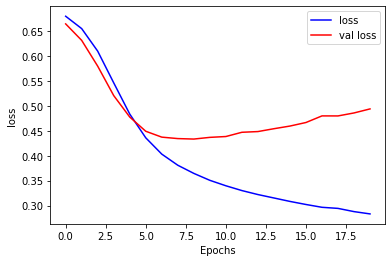

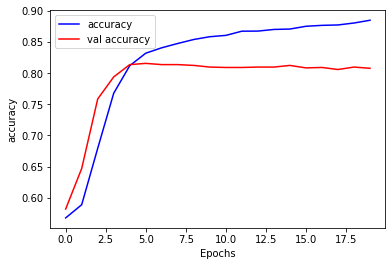

In [46]:
plot_history(base_history)

In [47]:
print("-"*25 + 'TRAIN' + "-"*25)
display_metrics(ytrain, ytrain_pred_base)
print("-"*25 + 'VALIDATION' + "-"*25)
display_metrics(yval, yval_pred_base)

-------------------------TRAIN-------------------------
f1-score:  0.8669833729216152
precision:  0.9057071960297767
recall:  0.8314350797266514
acuracy:  0.8896551724137931
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      3456
           1       0.91      0.83      0.87      2634

    accuracy                           0.89      6090
   macro avg       0.89      0.88      0.89      6090
weighted avg       0.89      0.89      0.89      6090

-------------------------VALIDATION-------------------------
f1-score:  0.7615947925142392
precision:  0.7905405405405406
recall:  0.7346938775510204
acuracy:  0.8076165462902167
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       886
           1       0.79      0.73      0.76       637

    accuracy                           0.81      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.81      0.81      0.81     

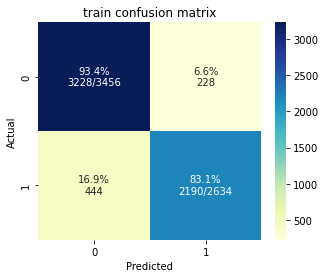

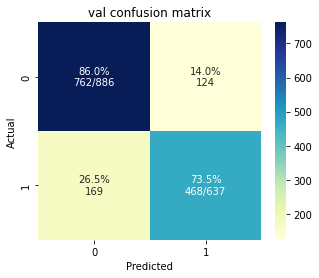

In [48]:
plot_cm(ytrain, ytrain_pred_base, 'train confusion matrix')
plot_cm(yval, yval_pred_base, 'val confusion matrix')

#### **SimpleRNN**

In [49]:
# load model and history
simpleRNN_history = json.load(open("./logs/history/simpleRNN_history.json", 'r'))
model_simpleRNN = tf.keras.models.load_model("./logs/model/model_simpleRNN.h5")

# prediction
ytrain_pred_simpleRNN = model_simpleRNN.predict(xtrain).round()
yval_pred_simpleRNN = model_simpleRNN.predict(xval).round()

48/48 [==============================] - 0s 2ms/step


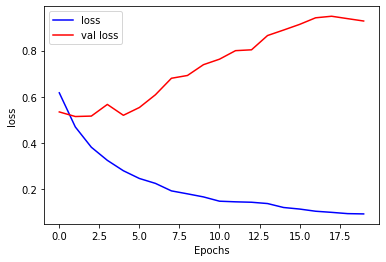

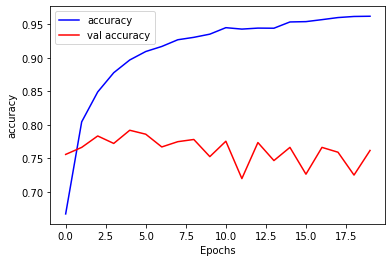

In [50]:
plot_history(simpleRNN_history)

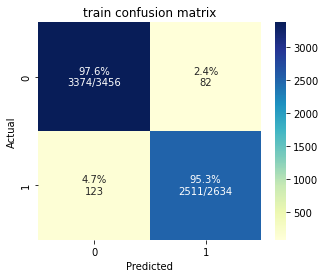

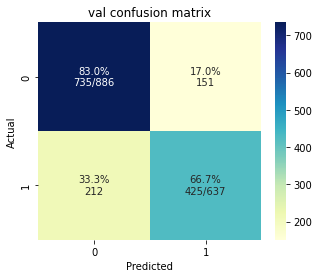

In [51]:
plot_cm(ytrain, ytrain_pred_simpleRNN, 'train confusion matrix')
plot_cm(yval, yval_pred_simpleRNN, 'val confusion matrix')

#### **GRU**

In [52]:
# load model and history
GRU_history = json.load(open("./logs/history/GRU_history.json", 'r'))
model_GRU = tf.keras.models.load_model("./logs/model/model_GRU.h5")

# prediction
ytrain_pred_GRU = model_GRU.predict(xtrain).round()
yval_pred_GRU = model_GRU.predict(xval).round()

48/48 [==============================] - 0s 2ms/step


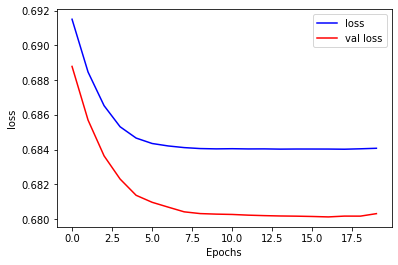

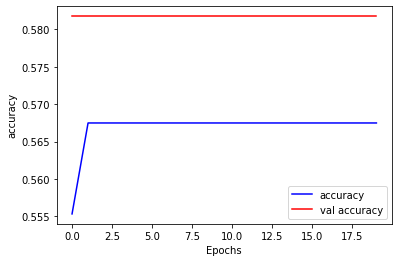

In [53]:
plot_history(GRU_history)

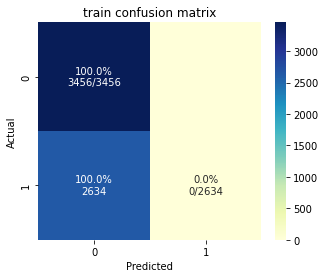

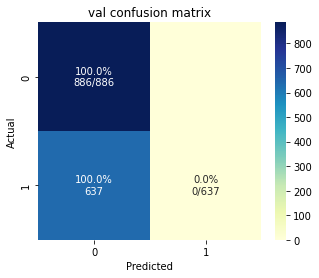

In [54]:
plot_cm(ytrain, ytrain_pred_GRU, 'train confusion matrix')
plot_cm(yval, yval_pred_GRU, 'val confusion matrix')

#### **LSTM**

In [55]:
# load model and history
LSTM_history = json.load(open("./logs/history/LSTM_history.json", 'r'))
model_LSTM = tf.keras.models.load_model("./logs/model/model_LSTM.h5")

# prediction
ytrain_pred_LSTM = model_LSTM.predict(xtrain).round()
yval_pred_LSTM = model_LSTM.predict(xval).round()

48/48 [==============================] - 0s 3ms/step


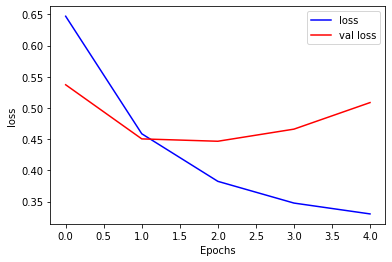

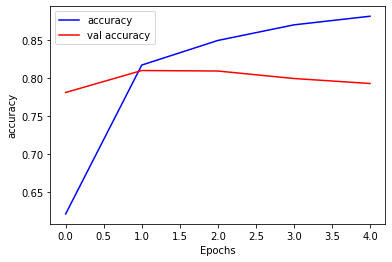

In [56]:
plot_history(LSTM_history)

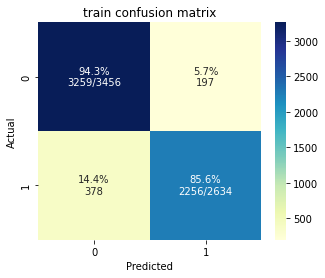

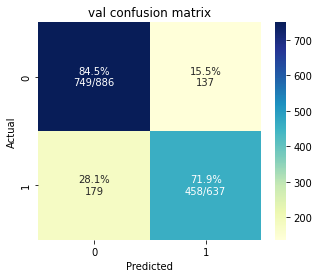

In [57]:
plot_cm(ytrain, ytrain_pred_LSTM, 'train confusion matrix')
plot_cm(yval, yval_pred_LSTM, 'val confusion matrix')

we are overfitting.
solutions: simplifying the model, adding drop-out layers, stop the learning process early.
These solutions didn't improve significantly our accuracy score

the more complex the model (LSTM > GRU > simpleRNN > base), the faster it converges toward an accuracy of ~ 80 % but there is always overfitting above this value. the base model is the best performing and the loss and val_loss decrease each other almost all along the learning process. Our RNN models don't learn anything from the sequentiality of the words inside a tweet.

### 5. Submission

In [58]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                # Couche d'Input Word Embedding           
                tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim = 16, input_length = 25, name="embedding"),
                # Global average pooling
                tf.keras.layers.GlobalAveragePooling1D(),
                # Couche Dense classique
                #tf.keras.layers.Dense(16, activation='relu'),
                tf.keras.layers.Dense(8, activation='relu'),
                # Couche de sortie avec une fonction d'activation sigmoid
                tf.keras.layers.Dense(1, activation="sigmoid")
])

optimizer= tf.keras.optimizers.Adam()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batch, 
                    epochs=8, 
                    validation_data=val_batch)

model.save("logs/model/model_final.h5")
json.dump(model.history.history, open("./logs/history/final_history.json", 'w'))

Epoch 1/8
96/96 [==============================] - 1s 2ms/step - loss: 0.6906 - accuracy: 0.5588 - val_loss: 0.6826 - val_accuracy: 0.5817
Epoch 2/8
96/96 [==============================] - 0s 1ms/step - loss: 0.6705 - accuracy: 0.5831 - val_loss: 0.6466 - val_accuracy: 0.6264
Epoch 3/8
96/96 [==============================] - 0s 1ms/step - loss: 0.6189 - accuracy: 0.6875 - val_loss: 0.5851 - val_accuracy: 0.7971
Epoch 4/8
96/96 [==============================] - 0s 1ms/step - loss: 0.5420 - accuracy: 0.7918 - val_loss: 0.5079 - val_accuracy: 0.7951
Epoch 5/8
96/96 [==============================] - 0s 1ms/step - loss: 0.4700 - accuracy: 0.8200 - val_loss: 0.4609 - val_accuracy: 0.8142
Epoch 6/8
96/96 [==============================] - 0s 1ms/step - loss: 0.4194 - accuracy: 0.8345 - val_loss: 0.4342 - val_accuracy: 0.8135
Epoch 7/8
96/96 [==============================] - 0s 1ms/step - loss: 0.3879 - accuracy: 0.8463 - val_loss: 0.4295 - val_accuracy: 0.8129
Epoch 8/8
96/96 [==========

In [59]:
model_final = tf.keras.models.load_model("./logs/model/model_final.h5")

In [60]:
ytest_pred = model_final.predict(text_test_pad).round().astype(int).reshape(3263)

102/102 [==============================] - 0s 564us/step


In [61]:
sub=pd.DataFrame({'id':test_df['id'].values.tolist(),'target':ytest_pred})
sub.to_csv('submission.csv',index=False)

Test accuracy score: 0.79589

## 6. Vizualising the embbeding

In [62]:
weights = model_LSTM.get_layer('embedding').get_weights()[0]
vocab = [value for value in tokenizer.index_word.values()][0:2000]

In [63]:
# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir='./logs/projector/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [64]:
from tensorboard.plugins import projector

# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
weights = tf.Variable(weights)
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [65]:
# Load the TensorBoard notebook extension
%load_ext tensorboard